## for Ashok: 
- Run this notebook with latest Pytorch version. `conda env : NLP_assignments_env`

In [5]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = 't5-small'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def cal_prob(target_text, input_ids, attention_mask, model, tokenizer, device):
    labels = tokenizer.encode(target_text, return_tensors="pt", padding=True).to(device)
    decoder_input_ids = torch.cat([torch.zeros_like(labels[:, :1]), labels[:, :-1]], dim=-1).to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, decoder_input_ids=decoder_input_ids)
    loss = outputs[0]
    text_prob = torch.exp(-loss)**(len(target_text))
    return text_prob


def format_text(hypothesis,premise):
    # “nli hypothesis: [hypothesis] premise: [premise]"
    return f"nli hypothesis: {hypothesis} premise: {premise}"


In [6]:

def get_probability(hypothesis,premise,model=model,tokenizer=tokenizer,device=device,format_text = format_text):

    input_text = format_text(hypothesis,premise)

    # Encode the input text
    # inputs = tokenizer.encode_plus(input_text, return_tensors="pt", padding=True)
    #set max length to max of 512 or the # of words in the input text
    n_words = len(input_text.split())
    max_len = max(512,n_words)
    inputs = tokenizer.encode_plus(input_text, return_tensors="pt", padding=True, max_length=max_len, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    ent_prob = cal_prob('entailment', input_ids, attention_mask, model, tokenizer, device)
    con_prob = cal_prob('contradiction', input_ids, attention_mask, model, tokenizer, device)

    probability = ent_prob / (ent_prob + con_prob)
    return probability.item() #, ent_prob.item(), con_prob.item()


In [9]:
hypothesis = "My name is jing ping. I am an alien from Andromeda galaxy."
premise = "jing ping loves spaceship travel"
primise2 = "jing ping hates noodles"
premise3 = "jing ping loves noodles"
print("example 1: ",get_probability(hypothesis,premise))
print("example 2: ",get_probability(hypothesis,primise2))
print("example 3: ",get_probability(hypothesis,premise3))

example 1:  5.533644798560999e-05
example 2:  0.9999989867210388
example 3:  5.51770654055872e-06


In [10]:
hypothesis = "My name is jing ping. I am a chinese student."
premise = "jing ping loves spaceship travel"
primise2 = "jing ping hates noodles"
premise3 = "jing ping loves noodles"
print("example 1: ",get_probability(hypothesis,premise))
print("example 2: ",get_probability(hypothesis,primise2))
print("example 3: ",get_probability(hypothesis,premise3))

example 1:  0.006590771488845348
example 2:  0.1209043562412262
example 3:  0.5932393074035645


# On validation set

In [4]:
import pandas as pd
import os
import json
import math


class Dataset:
    """ 
    gives preprocessed data suitable for giving to the SBERT model
    """
    def __init__(self,
                  file_path='data/train.json',
                  debug_level=0):
        
        self.df = pd.read_json(file_path)
        self.df = self.df.transpose()
        self.CTs_path = 'data/CTs/'

        self.debug_level = debug_level
    
    def __len__(self):
        return len(self.df)
    
    def extract_section(self,CTR_id, section_id):

        if type(CTR_id) != str and math.isnan(CTR_id):
            if self.debug_level > 0:
                print('CTR_id is nan')
            return []
        file_path = os.path.join(self.CTs_path, CTR_id + '.json')
        with open(file_path) as f:
            data = json.load(f)
            CTR = data[section_id]
        return CTR
    
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        section_id = sample['Section_id']
        statement = sample['Statement']
        primary_id = sample['Primary_id']
        secondary_id = sample['Secondary_id']
        primary_evidence_index = sample['Primary_evidence_index']
        secondary_evidence_index = sample['Secondary_evidence_index']
        label = sample['Label']

        CTR_1 = self.extract_section(primary_id, section_id)
        CTR_2 = self.extract_section(secondary_id, section_id)
        
        # premise = f" Primary Trial : {CTR_1} Secondary Trial : {CTR_2} "
        # join the list of sentences inside CTR_1 and CTR_2
        # return CTR_1#, CTR_2, statement, label
        premise = f" Primary Trial : {' '.join(CTR_1)} Secondary Trial : {' '.join(CTR_2)} "
        hypothesis = statement
        
        return {
            "hypothesis": hypothesis,
            "premise": premise,
            "label": label
        }
        

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [5]:
dataset = Dataset(file_path="data/dev.json")

a = dataset[0]

In [6]:
# get_probability(dataset[0]['hypothesis'],dataset[0]['premise']), dataset[0]['label']
for i in range(10):
    print(get_probability(dataset[i]['hypothesis'],dataset[i]['premise']), dataset[i]['label'])

0.9999979138374329 Contradiction
0.999725341796875 Contradiction
1.0 Contradiction
0.006264683324843645 Entailment
0.3753003478050232 Contradiction
0.9762654304504395 Contradiction
0.00012179980694781989 Contradiction
0.9999517202377319 Entailment
0.518434464931488 Contradiction
0.008045013062655926 Entailment


# with T5 Large

In [6]:
# using t5 large model
model_name = 't5-large'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)


/home/pikachu/anaconda3/envs/NLP_assignments_env/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:173: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [7]:
# on few samples
for i in range(10):
    model = model.to(device)
    
    prob = get_probability(dataset[i]['hypothesis'],dataset[i]['premise'],
                           model=model,
                           tokenizer=tokenizer,
                            device=device)
    print(prob, dataset[i]['label'])

0.9999595284461975 Contradiction
0.5132889151573181 Contradiction
1.0 Contradiction
0.9351097941398621 Entailment
0.2582264244556427 Contradiction
0.9175063967704773 Contradiction
0.9999942779541016 Contradiction
1.0 Entailment
1.0 Contradiction
0.13497444987297058 Entailment


In [8]:
# running on the entire val set
prediction_probabilities =[]
GT_labels = []
for i in range(len(dataset)):
    prob = get_probability(dataset[i]['hypothesis'],dataset[i]['premise'],
                           model=model,
                           tokenizer=tokenizer,
                            device=device)
    prediction_probabilities.append(prob)
    GT_labels.append(dataset[i]['label'])
    

In [19]:
# get the accuracy
import numpy as np
from sklearn.metrics import accuracy_score
 
 
predictions = np.array(prediction_probabilities) > 0.5
predictions = predictions.astype(int)
 
labels = np.array( [int(x == 'Entailment') for x in GT_labels] )
 
labels = labels.astype(int)
 
print(accuracy_score(labels,predictions))
 
 


0.545


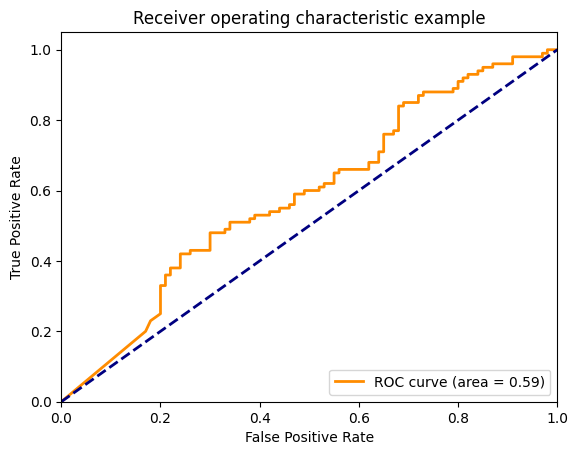

In [20]:

#roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
 
fpr, tpr, thresholds = roc_curve(labels, prediction_probabilities)
roc_auc = auc(fpr, tpr)
 
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()


In [21]:
 
# calculate other metrics F1, precision, recall
from sklearn.metrics import f1_score, precision_score, recall_score
 
f1 = f1_score(labels,predictions)
precision = precision_score(labels,predictions)
recall = recall_score(labels,predictions)
 
print( f"F1: {f1} \n Precision: {precision} \n Recall: {recall}")

F1: 0.5919282511210762 
 Precision: 0.5365853658536586 
 Recall: 0.66


# scifive 

In [ ]:
# with scifive model
model_name = 'razent/SciFive-large-Pubmed_PMC'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

model = model.to(device)
model.eval()

In [8]:
# running on the entire val set
prediction_probabilities =[]
GT_labels = []
for i in range(len(dataset)):
    prob = get_probability(dataset[i]['hypothesis'],dataset[i]['premise'],
                           model=model,
                           tokenizer=tokenizer,
                            device=device)
    prediction_probabilities.append(prob)
    GT_labels.append(dataset[i]['label'])
    

In [10]:
# get the accuracy
import numpy as np
from sklearn.metrics import accuracy_score
 
 
predictions = np.array(prediction_probabilities) > 0.5
predictions = predictions.astype(int)
 
labels = np.array( [int(x == 'Entailment') for x in GT_labels] )
 
labels = labels.astype(int)
 
print(accuracy_score(labels,predictions))

0.495


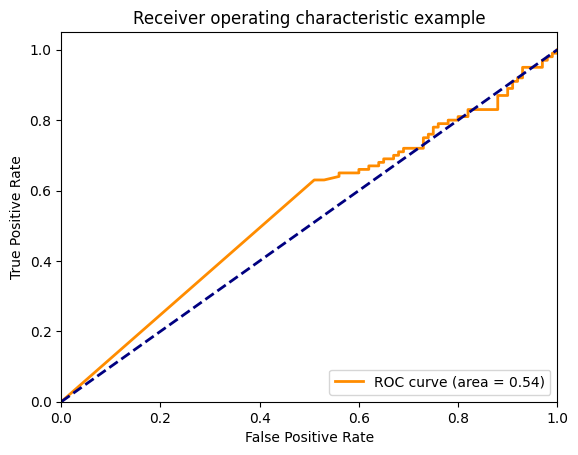

In [12]:
 #roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
 
fpr, tpr, thresholds = roc_curve(labels, prediction_probabilities)
roc_auc = auc(fpr, tpr)
 
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

In [14]:

 
# calculate other metrics F1, precision, recall
from sklearn.metrics import f1_score, precision_score, recall_score
 
f1 = f1_score(labels,predictions)
precision = precision_score(labels,predictions)
recall = recall_score(labels,predictions)
 
print( f"F1: {f1} \n Precision: {precision} \n Recall: {recall}")

F1: 0.6529209621993126 
 Precision: 0.4973821989528796 
 Recall: 0.95


# scifive with different format of input

In [25]:

def format_text_2(hypothesis,premise):
    # “nli hypothesis: [hypothesis] premise: [premise]"
    return f"Result is either 'Entailment' or 'Contradiction'. \n nli hypothesis: {hypothesis} premise: {premise}"




In [26]:
# running on the entire val set
prediction_probabilities =[]
GT_labels = []
for i in range(len(dataset)):
    prob = get_probability(dataset[i]['hypothesis'],dataset[i]['premise'],
                           model=model,
                           tokenizer=tokenizer,
                            device=device,
                            format_text = format_text_2)
    prediction_probabilities.append(prob)
    GT_labels.append(dataset[i]['label'])
    

In [27]:
# get the accuracy
import numpy as np
from sklearn.metrics import accuracy_score
 
 
predictions = np.array(prediction_probabilities) > 0.5
predictions = predictions.astype(int)
 
labels = np.array( [int(x == 'Entailment') for x in GT_labels] )
 
labels = labels.astype(int)
 
print(accuracy_score(labels,predictions))
 

0.49


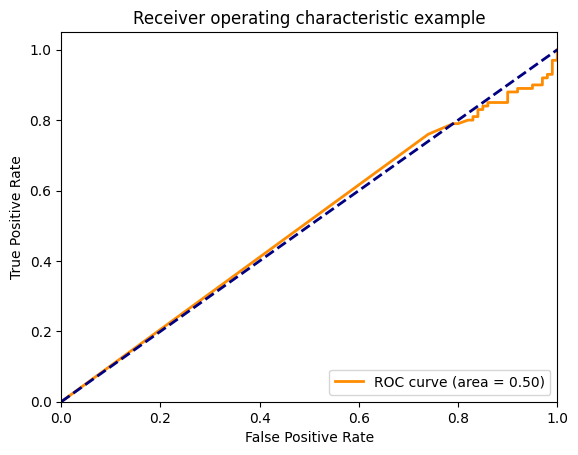

In [28]:
 #roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
 
fpr, tpr, thresholds = roc_curve(labels, prediction_probabilities)
roc_auc = auc(fpr, tpr)
 
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

In [29]:

 
# calculate other metrics F1, precision, recall
from sklearn.metrics import f1_score, precision_score, recall_score
 
f1 = f1_score(labels,predictions)
precision = precision_score(labels,predictions)
recall = recall_score(labels,predictions)
 
print( f"F1: {f1} \n Precision: {precision} \n Recall: {recall}")

F1: 0.6577181208053691 
 Precision: 0.494949494949495 
 Recall: 0.98
